# Duration Tests

You can specify a build number in the **current_build** variable to generate a report for a specific build version, or change the **release** variable.

With the **parameters** dictionary, you can specify the **os** and the **maximum** data values shown. Changing the **url** to `True` or `False` will determine whether or not data points in the scatter plot willbe clickable. It is noteworthy that starting around 1500 data points, clickable links will cease to work.

The **component** key takes a list. When defined, only data where the component matches one of the items in the list will be shown. The **area** key also takes a list. When defined, only data where the area matches one of the items in the list will be shown. Commenting out or deleting one of their lines will remove that filter.

example:
```
parameters = {
    "os": "centos",
    "maximum": "15",
    "component": ["ipv6"],
    "area": ["xdcr", "2i", "eventing", "bucket"],
    "url": True
}
```
will show the first 15 results of tests under the *ipv6* component with areas or *xdcr, 2i, eventing, or bucket*.

In [86]:
release="7.1.0"
current_build=""

parameters = {
    "os": "centos",
    "maximum": "1500",
    "component": ["durability"],
    "area": ["query", "transaction"],
    "url": False
}

In [87]:
import requests
import json
import webbrowser

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import plotly
from plotly.offline import *
import plotly.figure_factory as ff

plt.rcParams['figure.figsize'] = (20.0, 12.0)
plt.rcParams['font.family'] = "serif"

In [88]:
def run_query(query, host="172.23.99.54", port=8093, username="Administrator", password="password", param=None):
    url_base = f"http://{host}:{port}/query/service"
    params = {'statement': query, 'scan_consistency': 'REQUEST_PLUS'}
    if param:
        params.update(param)
    response = requests.get(url=url_base, params=params, auth = requests.auth.HTTPBasicAuth(username, password))
    return response.json()

In [89]:
if type(current_build) != type("") or len(str(current_build)) != 4:
    query_current_weekly_build = f'SELECT raw `build` FROM server WHERE `build` < "{release}." GROUP BY `build` HAVING sum(totalCount) > 10000 ORDER BY `build` DESC LIMIT 1'
    current_result = run_query(query=query_current_weekly_build, param={'$version': f'"{release}-0000"'})
    current_build = current_result['results'][0].split("-", 1)[1]

In [90]:
def construct_component_query():
    if "component" in parameters:
        component_base = f'(LOWER(component)=' if "component" in parameters else ""
        component_query = f'({component_base}"{parameters["component"][0]}") '
        if len(parameters["component"]) > 1:
            for c in range(1, len(parameters["component"])):
                component_query = f'{component_query} OR {component_base}"{parameters["component"][c]}")'
        component_query = component_query + ') AND'
        return component_query
    else:
        return ""
    
def construct_area_query():
    if "area" in parameters:
        area_base = f'(SPLIT(REPLACE(REPLACE(REPLACE(SPLIT(name,"-")[1], "os_certify_ce_", ""), "ipv6_", ""), "os_certify_", ""), "_")[0]=' if "area" in parameters else ""
        area_query = f'({area_base}"{parameters["area"][0]}") '
        if len(parameters["area"]) > 1:
            for a in range(1, len(parameters["area"])):
                area_query = f'{area_query} OR {area_base}"{parameters["area"][a]}")'
        area_query = area_query + ') AND'
        return area_query
    else:
        return ""

# Scatter Plot

This scatter plot will represent the duration of each test over its fail count. Hover near each dot to see more detailed information about it.

At the top right of the figure, there will be a toolbar when the cursor is over the graph. Selecting different tools allows the user to notably pan around (Pan), rescale the graph to only show a selected portion (Box Select), reset the graph to its original state (Autoscale or Reset axes), or zoom in and out.

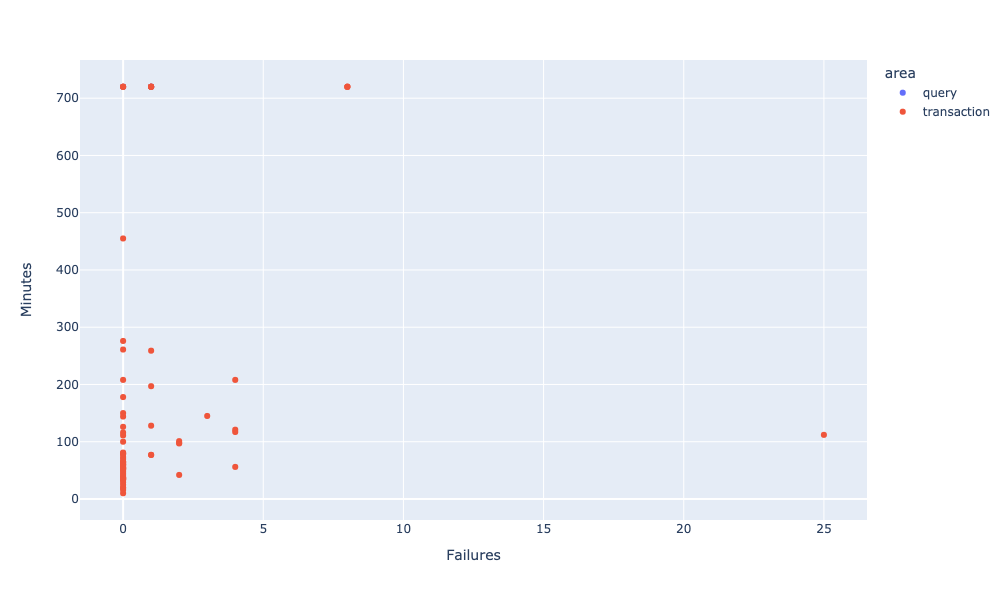

In [91]:


search_area = 'SPLIT(REPLACE(REPLACE(REPLACE(SPLIT(name,"-")[1], "os_certify_ce_", ""), "ipv6_", ""), "os_certify_", ""), "_")[0]'
limit_query = f'LIMIT {parameters["maximum"]}' if "maximum" in parameters else ""
duration_query = f'SELECT component, url || to_string(build_id) as `url`, name, round(duration/1000/60) AS minutes, os, failCount as fail_count, {search_area} as area FROM server WHERE LOWER(os)="{parameters["os"]}" AND {construct_component_query()} {construct_area_query()} `build`="{release}-{current_build}" {limit_query};'

duration_result = run_query(query=duration_query, param={'$version': f"'{release}-{current_build}'"})
duration = pd.DataFrame(duration_result['results'])


duration = duration.fillna("no area")

if parameters["url"]:
    def make_clickable(url, name):
        return '<a href="{}" target="_blank" style="opacity: 0">•</a>'.format(url,name)
    if "url" in duration:
        duration['url'] = duration.apply(lambda x: make_clickable(x['url'], x['name']), axis=1)
else:
    duration = duration.assign(url="")

if len(duration) > 0:
    duration_fig = px.scatter(duration, x="fail_count", y="minutes", color="area", text="url", hover_data={"url": False, "name": True, "component": True})
    duration_fig.update_layout(height=600, yaxis_title_text="Minutes", xaxis_title_text="Failures")
    duration_fig.show()
else:
    print("query found no matching data")

# Histogram

Plotly offers a few ways to express the same data. Here, there is a simple histogram of the same data that the scatter plot uses. You can change the **bar_mode** variable to one of the following options: "stack", "group", "overlay", or "relative" to adjust to needs. 

In [92]:
bar_mode="stack"

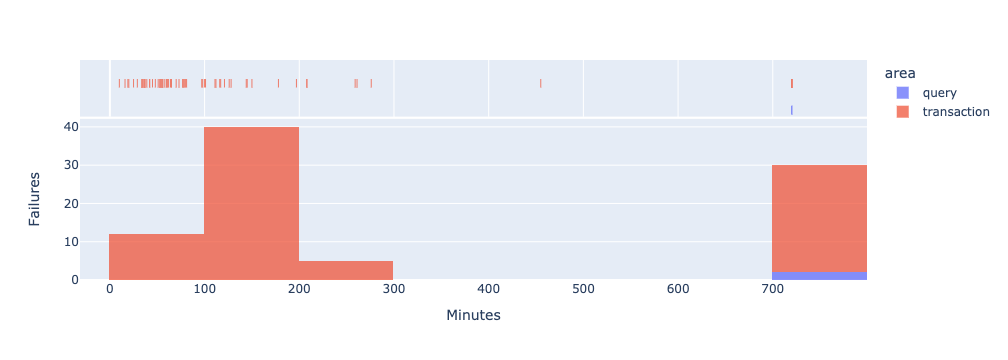

In [93]:
hist_fig = px.histogram(duration, x="minutes", y="fail_count", color="area", hover_data=duration.columns, marginal="rug")
hist_fig.update_layout(barmode=bar_mode, bargroupgap=0, bargap=0, xaxis_title_text="Minutes", yaxis_title_text="Failures")
hist_fig.update_traces(opacity=0.75)

hist_fig.show()